In [1]:
import numpy as np
import pandas as pd
from scipy.stats import expon, gamma, powerlaw, pareto
import matplotlib.pyplot as plt

np.random.seed(41)

TOTAL_TIME = 10800
NUM_LEVELS = 5
TICK_SIZE = 0.01
INITIAL_MID_PRICE = 170.96
LAMBDA_GLOBAL = 50
LEVEL_WEIGHTS = [0.5, 0.2, 0.15, 0.1, 0.05]
INTRA_DAY_BOOST = {0: 1.0, 10800: 1.0, 21600: 2.0} # 9:00, 12:00, 15:00

EVENT_PROBS = {'L': 0.45, 'C': 0.45, 'M': 0.10}

def initialize_lob():
    bid_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()
    ask_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()
    bid_prices = [INITIAL_MID_PRICE - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    ask_prices = [INITIAL_MID_PRICE + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    return bid_queues, ask_queues, bid_prices, ask_prices

def simulate_lob_stylized_facts():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    prev_events = []
    lambda_entries = []

    while t < TOTAL_TIME:
        lambda_scale = 1.0
        for time, boost in INTRA_DAY_BOOST.items():
            if t >= time:
                lambda_scale = boost

        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        q_before = queues[level]

        lambda_global_adjusted = LAMBDA_GLOBAL * lambda_scale

        excitation = 0
        for prev_t, prev_type in prev_events[-10:]:
            dt = t - prev_t
            if dt > 0:
                excitation += 0.5 * np.exp(-0.05 * dt)
        lambda_global_final = max(0.1, lambda_global_adjusted + excitation)

        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt

        lambda_entries.append({
            'time': t,
            'lambda': lambda_global_final
        })


        if t > TOTAL_TIME:
            break

        event_type = np.random.choice(['L', 'C', 'M'], p=[EVENT_PROBS['L'], EVENT_PROBS['C'], EVENT_PROBS['M']])

        size = powerlaw.rvs(2.5, loc=1, scale=30, size=1)[0]
        size = max(1, min(30, size))
        #size = pareto.rvs(2.5, scale=1.5/2.5)

        if event_type == 'L':
            queues[level] += size
        elif event_type == 'C' and q_before > 0:
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
        elif event_type == 'M':
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                rem_size = size
                while rem_size > 0 and opp_queues:
                    available = opp_queues[0]
                    if rem_size < available:
                        opp_queues[0] -= rem_size
                        rem_size = 0
                    else:
                        rem_size -= available
                        opp_queues[0] = 0
                        
                        if np.random.random() < 0.7:
                            if side == 'bid':
                                mid_price = mid_price + 0.5 * TICK_SIZE
                            else:
                                mid_price = mid_price - 0.5 * TICK_SIZE
                            if side == 'bid':
                                ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                            else:
                                bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                        # 在原地补充被耗尽的订单（基于gamma分布）
                        opp_queues[0] = gamma.rvs(a=2, scale=10)

        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
        prev_events.append((t, event_type))
        if len(prev_events) > 100:
            prev_events.pop(0)

    lambda_entries = pd.DataFrame(lambda_entries)

    return pd.DataFrame(events), bid_queues, ask_queues, bid_prices, ask_prices, lambda_entries

def compute_stats(df):
    stats = {}
    for level in range(1, NUM_LEVELS + 1):
        level_df = df[df['level'] == level]
        stats[level] = {
            '#L': len(level_df[level_df['type'] == 'L']),
            '#C': len(level_df[level_df['type'] == 'C']),
            '#M': len(level_df[level_df['type'] == 'M']),
            'AES': level_df['size'].mean(),
            'AIT': np.diff(level_df['time']).mean() * 1000 if len(level_df) > 1 else np.nan
        }
    
    unique_times = np.unique(df['time'])
    price_changes = np.diff(df['mid_price'].reindex(unique_times, method='ffill'))
    annualized_volatility = price_changes.std() * np.sqrt(252 * 32400)
    
    stats_df = pd.DataFrame(stats).T
    stats_df.loc['Volatility'] = np.nan
    stats_df.at['Volatility', 'Volatility'] = annualized_volatility
    
    return stats_df

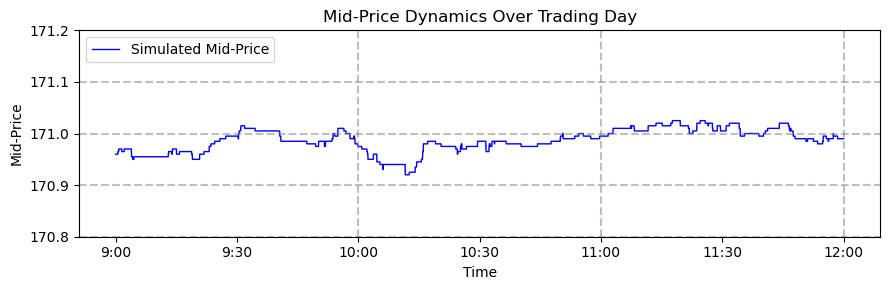

In [8]:
#stylized_data, stylized_bid_queues, stylized_ask_queues, stylized_bid_prices, stylized_ask_prices,lambda_list = simulate_lob_stylized_facts()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)

plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
time_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
time_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout() 
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [11]:
a1, b1, c1 = 64.459, 0.103, 4.932
a2, b2, c2 = 53.086, 0.110, 5.331
a3, b3, c3 = 4.900, 0.122, 0.145

def l1(x):
    if x < 4:
        return 15 + x*18/4
    if x < 8:
        return 33
    return a1 * np.exp(-b1 * x) + c1
def l2(x):
    if x < 4:
        return 10 + 4*x
    if x < 8:
        return 27
    return a2 * np.exp(-b2 * x) + c2
def l3(x):
    return a3 * np.exp(-b3 * x) + c3

In [17]:
def simulate_saqr():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    prev_events = []
    lambda_entries = []
    lambdas = []

    while t < TOTAL_TIME:

        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        
        q_before = queues[level]
        q = q_before
        lambda1, lambda2, lambda3 = l1(q), l2(q), l3(q)
        event_weights = [lambda1, lambda2, lambda3]
        event_prob = np.array(event_weights) / sum(event_weights)
        
        event_type = np.random.choice(['L', 'C', 'M'], p=event_prob)
        if event_type == 'L':
            lambda0 = lambda1
        elif event_type == 'C':
            lambda0 = lambda2
        else:
            lambda0 = lambda3
        
        lambdas.append((lambda1, lambda2, lambda3))
        
        lambda_global_adjusted = LAMBDA_GLOBAL * lambda_scale
        lambda_global_final = 40

        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt

        lambda_entries.append({
            'time': t,
            'lambda': lambda_global_final
        })

        if t > TOTAL_TIME:
            break
        
        
        #size = order_size(q)
        size = pareto.rvs(2.5, scale=1)
        #size = max(1, min(30, size))

        if event_type == 'L':
            queues[level] += size
        elif event_type == 'C' and q_before > 0:
            if np.random.random() < np.exp(-3):
                size = 30
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
        elif event_type == 'M':
            if np.random.random() < np.exp(-2):
                size = 30
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                rem_size = size
                while rem_size > 0 and opp_queues:
                    available = opp_queues[0]
                    if rem_size < available:
                        opp_queues[0] -= rem_size
                        rem_size = 0
                    else:
                        rem_size -= available
                        opp_queues[0] = 0
                        
                        if np.random.random() < 0.7:
                            opp_queues.pop(0)
                            opp_queues.append(gamma.rvs(a=2, scale=10))
                            if side == 'bid':
                                mid_price = mid_price + 0.5 * TICK_SIZE
                            else:
                                mid_price = mid_price - 0.5 * TICK_SIZE
                            if side == 'bid':
                                ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                            else:
                                bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                        else:
                            pass
                            #opp_queues[0] = gamma.rvs(a=2, scale=10)

        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
        prev_events.append((t, event_type))
        if len(prev_events) > 100:
            prev_events.pop(0)

    lambda_entries = pd.DataFrame(lambda_entries)

    return pd.DataFrame(events), bid_queues, ask_queues, bid_prices, ask_prices, lambda_entries, prev_events, lambdas

In [33]:
TOTAL_TIME = 5400

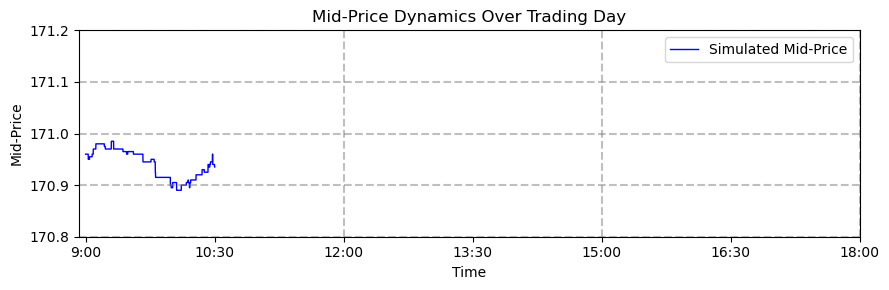

In [19]:
stylized_data, stylized_bid_queues, stylized_ask_queues, stylized_bid_prices, stylized_ask_prices,lambda_list, prev_events, lambdas = simulate_saqr()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)

plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=6, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=9, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [20]:
df_grouped = stylized_data.groupby(['side', 'level'])['queue_before'].mean()
df_grouped

side  level
ask   1        13.272191
      2        15.222923
      3        16.318488
      4        18.087986
      5        19.100623
bid   1        13.128821
      2        15.847891
      3        17.131839
      4        18.333461
      5        19.928099
Name: queue_before, dtype: float64

In [24]:
df_filtered = stylized_data[(stylized_data['side'] == 'bid') & (stylized_data['level'] == 1)]
df_filtered['type'].value_counts(normalize=True) # normalize=True

type
L    0.520480
C    0.427644
M    0.051876
Name: proportion, dtype: float64

C:\Users\Nvve\AppData\Local\Temp\ipykernel_14952\2420610509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


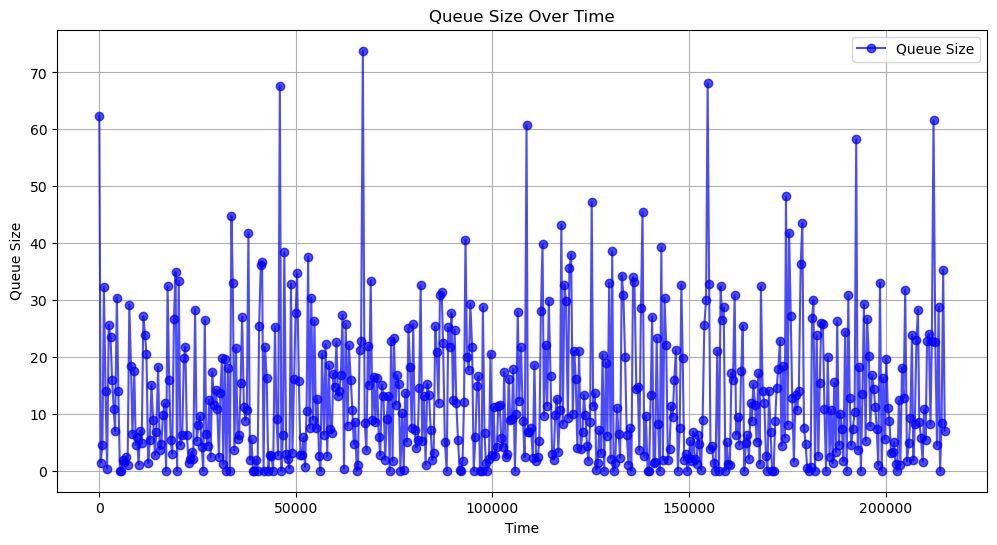

In [25]:
df_filtered = stylized_data[(stylized_data['side'] == 'bid') & (stylized_data['level'] == 1)]
df = df_filtered.iloc[::100]
import matplotlib.pyplot as plt

# 确保 'time' 是 datetime 类型
df['time'] = pd.to_datetime(df['time'])

# 按时间排序（避免乱序）
#df = df.sort_values(by='time')

# 绘制曲线图
plt.figure(figsize=(12, 6))
plt.plot(df['queue_before'], marker='o', linestyle='-', color='b', alpha=0.7, label='Queue Size')

# 添加标题和标签
plt.xlabel('Time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.legend()
#plt.xticks(rotation=45)  # 旋转 x 轴刻度
plt.grid()

# 显示图像
plt.show()

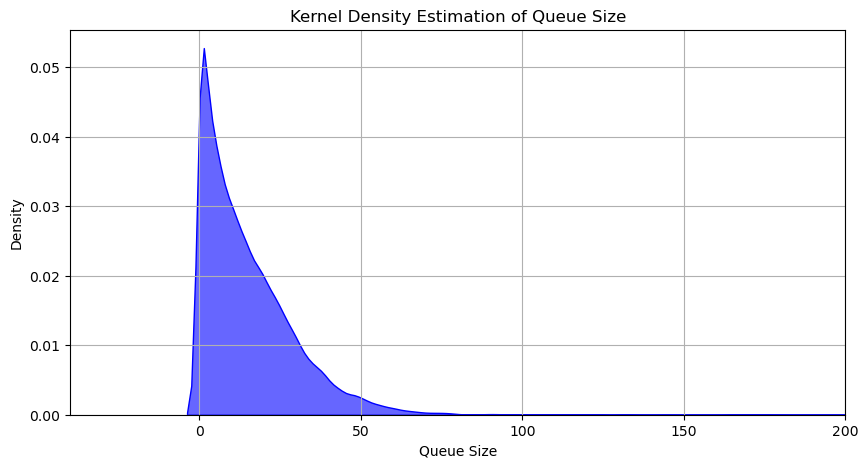

In [27]:
#df = df_filtered
df = stylized_data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(df['queue_before'], fill=True, color='blue', alpha=0.6)

# 限制 x 轴范围
plt.xlim(-40, 200)  # 让 x 轴最大值为 200

plt.xlabel('Queue Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Queue Size')
plt.grid()
plt.show()

In [2]:
a1, b1, c1 = 64.459, 0.103, 4.932
a2, b2, c2 = 53.086, 0.110, 5.331
a3, b3, c3 = 4.900, 0.122, 0.145
a5, b5, c5 = 4.363, 0.502, 0.122

def l1(x):
    if x < 4:
        return 15 + x*18/4
    if x < 8:
        return 33
    return a1 * np.exp(-b1 * x) + c1
def l2(x):
    if x < 4:
        return 10 + 4*x
    if x < 8:
        return 27
    return a2 * np.exp(-b2 * x) + c2
def l3(x):
    return max(a3 * np.exp(-b3 * x) + c3, 0)
def l4(x):
    if x < 2.5:
        return -1.3*x + 3.5
    else:
        return max(-0.1*x + 0.5, 0)
def l5(x):
    return max(a5 * np.exp(-b5 * x) + c5, 0)

In [3]:
from tqdm import tqdm

In [4]:
def simulate_saqr():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating SAQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:

        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        
        q_before = queues[level]
        q = q_before
        lambda1, lambda2, lambda3, lambda4, lambda5 = l1(q), l2(q), l3(q), l4(q), l5(q)
        event_weights = [lambda1, lambda2, lambda3, lambda4, lambda5]
        event_prob = np.array(event_weights) / sum(event_weights)
        
        event_type = np.random.choice(['L', 'C', 'M', 'CA', 'MA'], p=event_prob)
        
        #lambda_global_adjusted = LAMBDA_GLOBAL * lambda_scale
        lambda_global_final = 40

        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt
        progress_bar.update(dt)
        if t > TOTAL_TIME:
            break
        
        
        #size = order_size(q)
        size = pareto.rvs(2.5, scale=1.5/2.5)
        #size = max(1, min(30, size))
        if event_type == 'CA' or event_type == 'MA':
            size = queues[level]
                
                
        if event_type == 'L':
            queues[level] += size
        else:
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                rem_size = size
                while rem_size > 0 and opp_queues:
                    available = opp_queues[0]
                    if rem_size < available:
                        opp_queues[0] -= rem_size
                        rem_size = 0
                    else:
                        rem_size -= available
                        opp_queues[0] = 0
                        
                        if np.random.random() < 0.7:
                            opp_queues.pop(0)
                            opp_queues.append(gamma.rvs(a=2, scale=10))
                            opp_queues.insert(0, 0)
                            opp_queues.pop()
                            if side == 'bid':
                                mid_price = mid_price + 0.5 * TICK_SIZE
                            else:
                                mid_price = mid_price - 0.5 * TICK_SIZE
                            if side == 'bid':
                                ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                            else:
                                bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                        else:
                            pass
                            #opp_queues[0] = gamma.rvs(a=2, scale=10)

        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
    progress_bar.close()
    return pd.DataFrame(events)

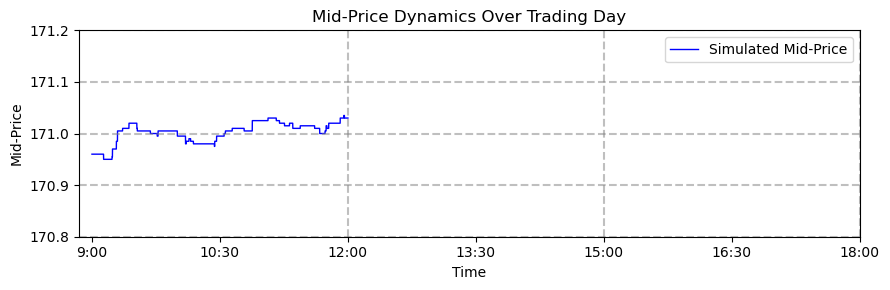

In [11]:
#stylized_data = simulate_saqr()
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')
hours = (times / 3600)

plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]
plt.xticks(time_values, time_labels)
plt.yticks([170.8,170.9,171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.9, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=170.8, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=6, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=9, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('results/images/simul_mid_price_dynamics.png')
plt.show()

In [5]:
def simulate_saqr():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    prev_events = []
    lambda_entries = []
    lambdas = []
    progress_bar = tqdm(total=TOTAL_TIME, desc="Simulating SAQR", unit="time", dynamic_ncols=True)
    
    while t < TOTAL_TIME:

        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        
        q_before = queues[level]
        q = q_before
        lambda1, lambda2, lambda3, lambda4, lambda5 = l1(q), l2(q), l3(q), l4(q), l5(q)
        event_weights = [lambda1, lambda2, lambda3, lambda4, lambda5]
        event_prob = np.array(event_weights) / sum(event_weights)
        
        event_type = np.random.choice(['L', 'C', 'M', 'CA', 'MA'], p=event_prob)
        
        
        lambda_global_final = 40

        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt
        progress_bar.update(dt)
        
        lambda_entries.append({
            'time': t,
            'lambda': lambda_global_final
        })

        if t > TOTAL_TIME:
            break
        
        
        #size = order_size(q)
        size = pareto.rvs(2.5, scale=1)
        #size = max(1, min(30, size))
        if event_type == 'CA' or event_type == 'MA':
            size = queues[level]
            
        if event_type == 'L':
            queues[level] += size
        elif event_type == 'C' or event_type == 'CA':
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
        elif event_type == 'M' or event_type == 'MA':
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                rem_size = size
                while rem_size > 0 and opp_queues:
                    available = opp_queues[0]
                    if rem_size < available:
                        opp_queues[0] -= rem_size
                        rem_size = 0
                    else:
                        rem_size -= available
                        opp_queues[0] = 0
                        
                        if np.random.random() < 0.7:
                            opp_queues.pop(0)
                            opp_queues.append(gamma.rvs(a=2, scale=10))
                            if side == 'bid':
                                mid_price = mid_price + 0.5 * TICK_SIZE
                            else:
                                mid_price = mid_price - 0.5 * TICK_SIZE
                            if side == 'bid':
                                ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                            else:
                                bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                        else:
                            pass
                            #opp_queues[0] = gamma.rvs(a=2, scale=10)

        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
        prev_events.append((t, event_type))
        if len(prev_events) > 100:
            prev_events.pop(0)

    lambda_entries = pd.DataFrame(lambda_entries)
    
    progress_bar.close()
    return pd.DataFrame(events)